# Randomized Autoencoder Ensembles for Unsupervised Outlier Detection

Daniel T. Soukup

### Contents
* [Data sets](#Data_sets)
* [Data scaling for training](#Data_scaling_for_training)
* [t-SNE visualization](#t-SNE_visualization)
* [Outlier detection baselines](#Outlier_detection_baselines)
* [Randomized autoencoders](#Randomized_autoencoders)
* [Outliers on the latent manifold](#Outliers_on_the_latent_manifold)
* [Detecting outliers based on reconstruction loss](#Detecting_outliers_based_on_reconstruction_loss)
* [Data loaders for adaptive learning](#Data_loaders_for_adaptive_learning)
* [Training the ensemble](#Training_the_ensemble)
* [Evaluating the ensemble](#Evaluating_the_ensemble)


In [15]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, cohen_kappa_score
from sklearn.manifold import TSNE

from tqdm import tqdm
import pickle

Our plan is to look into using autoencoders for outlier detection and in particular, test randomized autoencoder ensembles against some standard methods (Elliptic Envelopes, LOF and Isolation Forests). The autoencoder model will be based on [Jinghui Chen, Saket Sathe, Charu Aggarwal, Deepak Turaga. Outlier Detection with Autoencoder Ensembles. SIAM SDM, 2017](https://saketsathe.net/downloads/autoencode.pdf):

- we will fit autoencoders and measure the degree of outlier-ness by the reconstruction loss;
- the autoencoders are fit on random samples of the data and connections in the neural nets are dropped randomly to increase diversity;
- we train the models using adaptive sampling, using more and more data as the training progresses;
- we score each data point by the median reconstruction loss of our ensemble.


More resources:

- [Outlier book by C. Aggarval](http://charuaggarwal.net/outlierbook.pdf)
- [Outlier eval by Schubert et at](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2012/SDM12-outlierevaluation.pdf)
- [General resource collection](https://github.com/yzhao062/anomaly-detection-resources)

<a id="Data_sets"></a>
<h2 style="background-color:#9b96d9;"> Data sets </h2>

We will use some dummy data for sanity checks and some real world data too.

In [2]:
def generate_dummy(n_samples = 10000,
                    contamination = 0.03,
                    outlier_range = 2,
                    n_features = 2,
                    normalize=False):
    
    # normal inliers
    dummy_data = np.random.randn(n_samples, n_features)
    if normalize:
        noise = 1+np.random.randn(dummy_data.shape[0], 1)*0.1
        dummy_data = dummy_data/(np.linalg.norm(dummy_data, axis=1).reshape(-1, 1))
        dummy_data *= noise
        
    # uniform outliers from given range
    n_outliers = int(n_samples*contamination)
    dummy_data[:n_outliers, :] = np.random.uniform(-1*outlier_range, outlier_range, size=(n_outliers, n_features))
    
    dummy_data = pd.DataFrame(dummy_data, columns = range(n_features))
    dummy_data["Class"] = np.concatenate([np.ones((n_outliers,)), np.zeros((n_samples-n_outliers,))], axis=0)
    
    return dummy_data

dummy_data = generate_dummy(normalize=True)

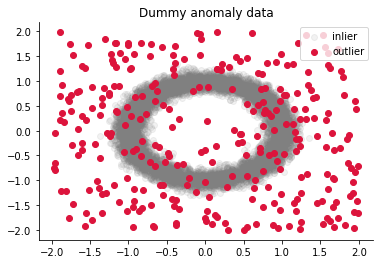

In [3]:
plt.figure()
plt.scatter(dummy_data.loc[dummy_data["Class"] == 0, 0], 
            dummy_data.loc[dummy_data["Class"] == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(dummy_data.loc[dummy_data["Class"] == 1, 0], 
            dummy_data.loc[dummy_data["Class"] == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("Dummy anomaly data")
plt.show()

In [4]:
dummy_data.Class.mean()

0.03

We will work with credit card data from [Wordline & ULB](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [2]:
#!pip install kaggle

import os 

os.makedirs("data", exist_ok=True)
if not os.path.exists("data/creditcard.csv"):
    

In [9]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [400]:
data.shape

(284807, 31)

The proportion of outliers is around 0.17%:

In [8]:
data["Class"].mean()

0.001727485630620034

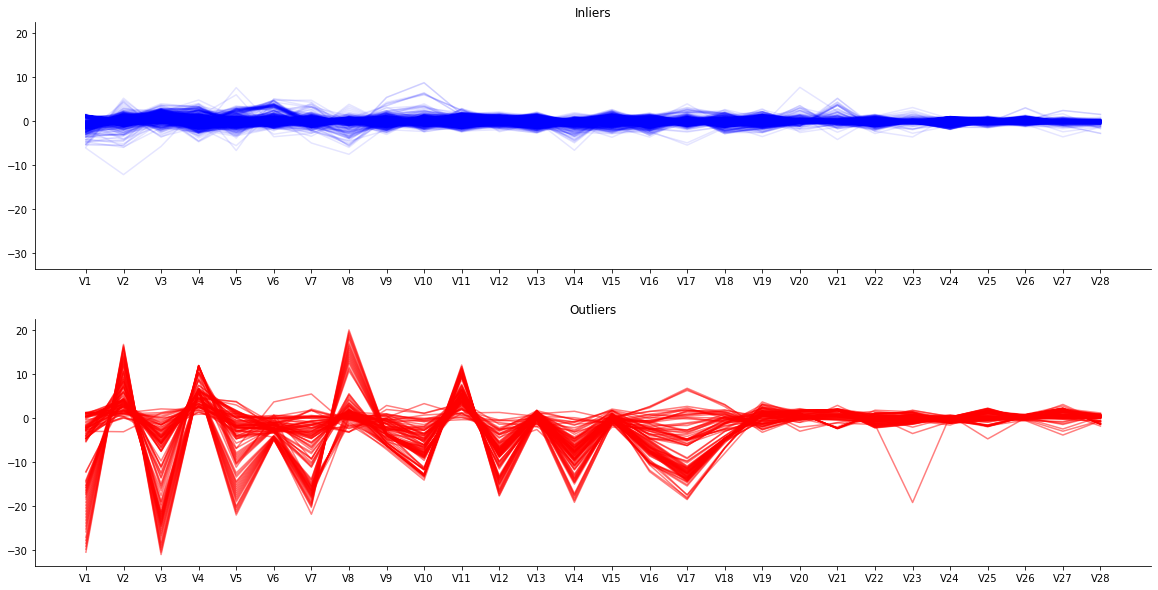

In [9]:
feature_cols = [col for col in data.columns if col.startswith("V")]

inlier_data = data[data.Class == 0].reset_index()
outlier_data = data[data.Class == 1].reset_index()

fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=True)
axs[0].plot(inlier_data.loc[:1000, feature_cols].T, c="blue", alpha=0.1)
axs[0].set_title("Inliers")
axs[1].plot(outlier_data.loc[:100, feature_cols].T, c="red", alpha=0.5)
axs[1].set_title("Outliers")
sns.despine()
plt.show()

The outliers are definitely showing different behaviour, much higher variance in many features. There also seems to some clustering among the inliers (around V5/6 there seems to be a distict group).

In [10]:
plot_data = data.melt(value_vars=feature_cols, 
                    id_vars=["Class"], 
                    var_name='groups', 
                    value_name='vals')

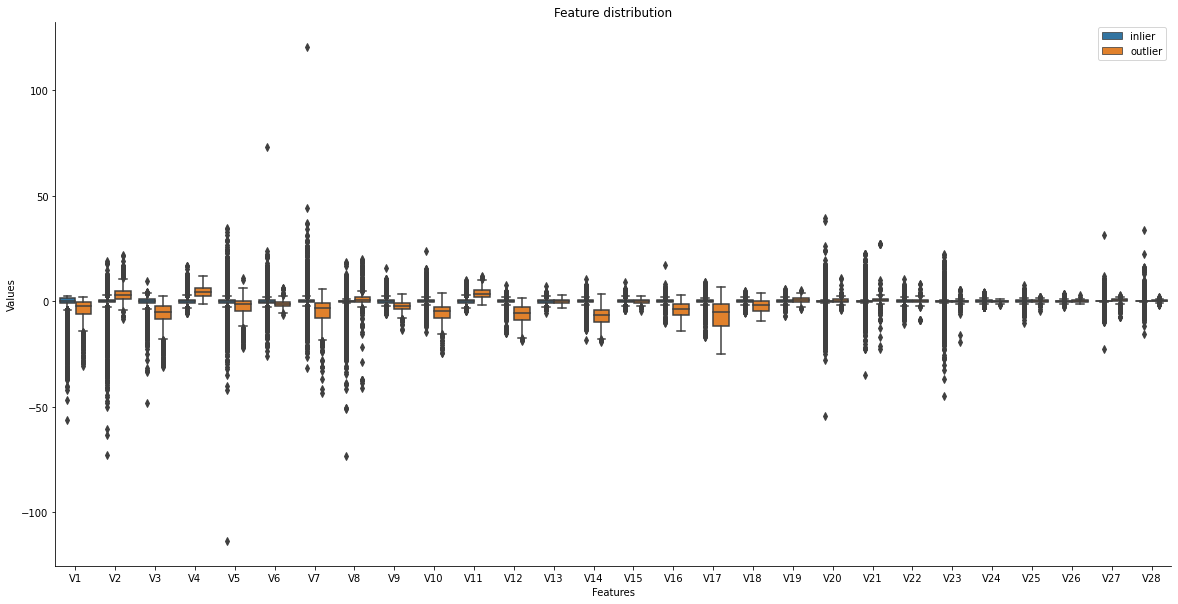

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x="groups", y="vals", hue="Class", data=plot_data, ax=axs)
sns.despine()
plt.xlabel("Features")
plt.ylabel("Values")
L=plt.legend()
L.get_texts()[0].set_text('inlier')
L.get_texts()[1].set_text('outlier')
plt.title("Feature distribution")
plt.show()

The data is centered and the variance is pretty much on the same scale for these features (not showing `Time` and `Amount`). 

In [12]:
feature_stats = data.drop("Class", axis=1).apply([np.std, np.mean]).T
feature_stats

,std,mean
Time,47488.145955,9.481386e+04
V1,1.958696,3.919560e-15
V2,1.651309,5.688174e-16
V3,1.516255,-8.769071e-15
V4,1.415869,2.782312e-15
V5,1.380247,-1.552563e-15
V6,1.332271,2.010663e-15
V7,1.237094,-1.694249e-15
V8,1.194353,-1.927028e-16
V9,1.098632,-3.137024e-15


Time and amount are on very different scales then the other (PCA) features of the data.

<a id="Data_scaling_for_training"></a>
<h2 style="background-color:#9b96d9;"> Data scaling for training </h2>

We will do just some basic preprocessing to standardize the data and also to map it between 0 and 1 (which is required by our autoencoder implementation with the final sigmoid layer).

In [32]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


class MyRobustScaler(TransformerMixin):
    def __init__(self, low_q=0.1, high_q=0.9):
        self.low_q = low_q
        self.high_q = high_q
        
        self.feature_low_bound = None
        self.feature_high_bound = None
    
    def fit(self, X):
        """
        Record per-feature quantiles.
        """
        self.feature_low_bound, self.feature_high_bound = np.quantile(X, [self.low_q, self.high_q], axis=0)
        
        return self
    
    def transform(self, X):
        """
        Limit the data between the quantiles.
        """
        X_transformed = np.where(X <= self.feature_low_bound, self.feature_low_bound, X)
        X_transformed = np.where(X_transformed >= self.feature_high_bound, self.feature_high_bound, X_transformed)
        
        return X_transformed
    
qs_mm_scaler = Pipeline([
                    ("quantile_transform", QuantileTransformer(output_distribution="normal")),
                    ("minmax", MinMaxScaler())
])

mm_scaler = Pipeline([("minmax", MinMaxScaler())])

own_scaler = Pipeline([("own_robust", MyRobustScaler()), 
                       ("minmax", MinMaxScaler())])

In [33]:
scaler = own_scaler

X = data.drop("Class", axis=1).values
y = data["Class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [402]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845, 1), (56962, 30), (56962, 1))

In [15]:
y_train.sum(), y_test.sum()

(394, 98)

In [34]:
scaled_data = pd.DataFrame(data=np.concatenate([X_train, y_train], axis=1), columns=data.columns)

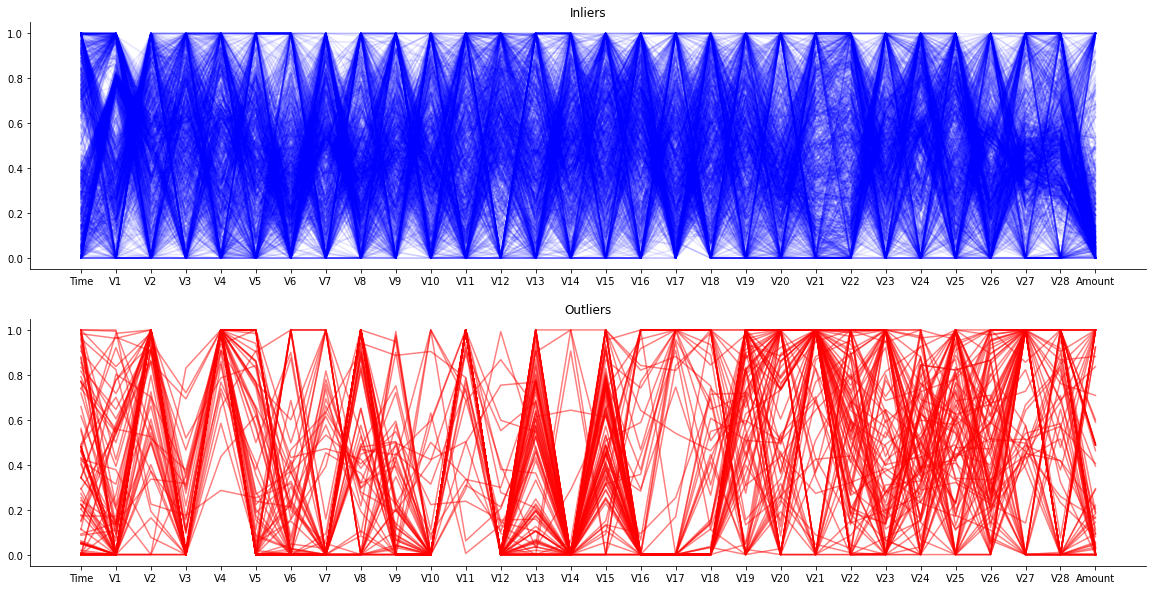

In [35]:
feature_cols = list(data.drop("Class", axis=1).columns)

inlier_data = scaled_data[scaled_data.Class == 0].reset_index()
outlier_data = scaled_data[scaled_data.Class == 1].reset_index()

fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=True)
axs[0].plot(inlier_data.loc[:1000, feature_cols].T, c="blue", alpha=0.1)
axs[0].set_title("Inliers")
axs[1].plot(outlier_data.loc[:100, feature_cols].T, c="red", alpha=0.5)
axs[1].set_title("Outliers")
sns.despine()
plt.savefig("wordline_features.png")
plt.show()

In [36]:
plot_data = scaled_data.melt(value_vars=feature_cols, 
                    id_vars=["Class"], 
                    var_name='groups', 
                    value_name='vals')

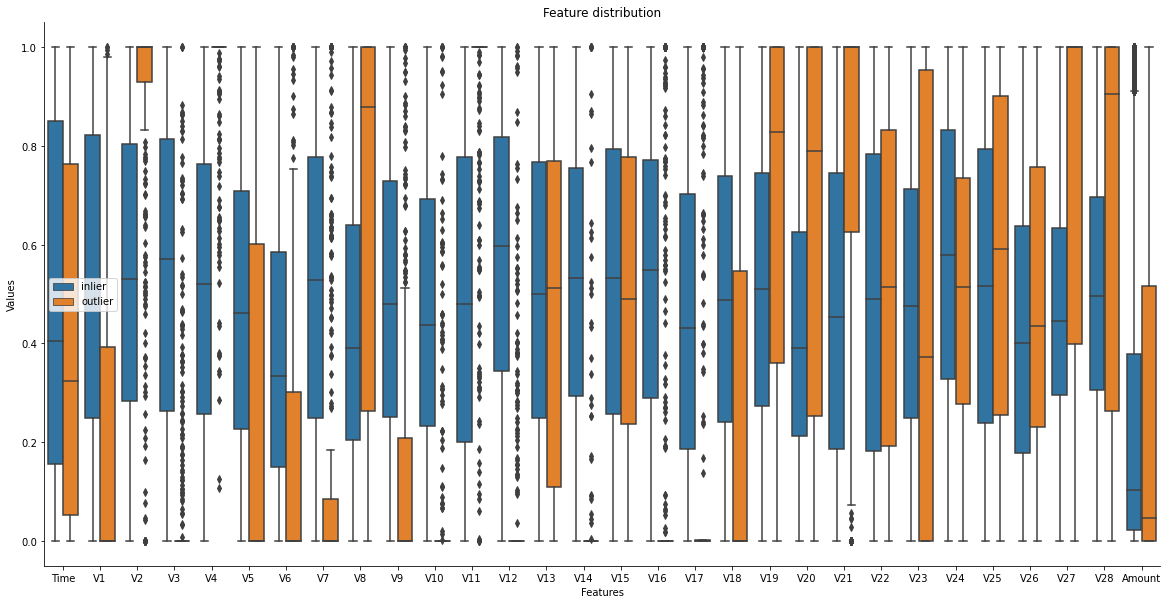

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x="groups", y="vals", hue="Class", data=plot_data, ax=axs)
sns.despine()
plt.xlabel("Features")
plt.ylabel("Values")
L=plt.legend()
L.get_texts()[0].set_text('inlier')
L.get_texts()[1].set_text('outlier')
plt.title("Feature distribution")
plt.show()

It is clear that the outliers have a very different marginal distribution on most features. This hopefully is a good sign that our scaling didn't destort too much the distinctive features of the outliers.

<a id="t-SNE_visualization"></a>
<h2 style="background-color:#9b96d9;"> t-SNE visualization </h2>

Before the modeling, we can visualize some of our data. We will pick 5000 inliers and all the outliers and see if there are some patterns.

In [20]:
inlier_sample = data.loc[data.Class == 0, feature_cols].sample(5000).values
outliers = data.loc[data.Class == 1, feature_cols].values

vis_data = np.concatenate([inlier_sample, outliers], axis=0)
vis_data = scaler.transform(vis_data)

vis_labels = np.concatenate([np.zeros((inlier_sample.shape[0],)), np.ones((outliers.shape[0],))])
vis_data.shape, vis_labels.shape

((5492, 30), (5492,))

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(vis_data)

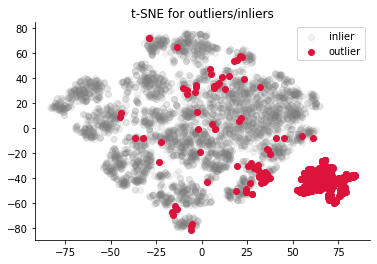

In [22]:
plt.figure()
plt.scatter(tsne_data[vis_labels == 0, 0], 
            tsne_data[vis_labels == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[vis_labels == 1, 0], 
            tsne_data[vis_labels == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers")
plt.savefig("tsne_wordline.png")
plt.show()

There is definitely strong separation among some of the outliers. But keeping in mind that we would like to do **unsupervised** outlier detection, it is not clear how we would tell apart the outlier clusters from some of the inlier blobs on the edge of the data (there is a fair amount of variation on the resulting plot here).

<a id="Outlier_detection_baselines"></a>
<h2 style="background-color:#9b96d9;"> Outlier detection baselines </h2>

We will use some [outlier detection baselines from sklearn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py).

In [ ]:
dummy_X = dummy_data.drop("Class", axis=1).values
dummy_y = dummy_data["Class"].values

### Elliptic Envelopes

Our first baseline is a paramteric method: by assuming that inlier data points are from a Gaussian distribution, we can measure the degree of outlier-ness by the fitted distribution. We perform a robust mean and covariance estimation (which should not be affected by outliers) and calculate the Mahalanobis distances to derive a measure of outlyingness. 

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope).

In [38]:
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, make_scorer


def eval_model(model, X, y):
    scoring = {"precision": precision_score, 
               "recall": recall_score, 
               "cohen": cohen_kappa_score} 

    results = pd.DataFrame(columns=scoring.keys())

    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {i}...", end="\r")
        model.fit(X[train_index])
        y_pred = model.predict(X[test_index])
        y_pred = np.where(y_pred == 1, 0, 1) 

        for name_, score in scoring.items():
            results.loc[i, name_] = score(y[test_index], y_pred) 
    
    return results

In [39]:
model = EllipticEnvelope(contamination=y_train.mean(), support_fraction=0.95)
results = eval_model(model, X_train, y_train)

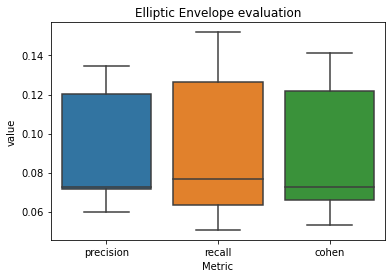

In [40]:
plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("Elliptic Envelope evaluation")
plt.show()


My own robust scaler seems to perform quite bad with elliptic envelopes...

It is worth a note that on unscaled data, this method was doing better (but since I will need some scaling for the AEs, I'll leave this as is).

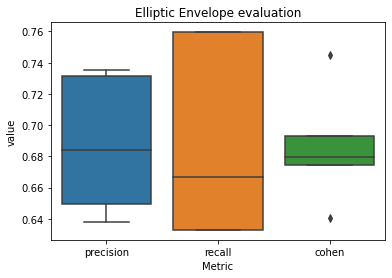

In [574]:
import warnings
warnings.filterwarnings('ignore') 
# the elliptic envelope fitting throws a lot of warnings
# I tried to change the support_fraction settings, but need to run more tests to look into this
# large values, around .95-.99 performed better though so keep an eye out for the warnings 

# I am dropping time and amount
# these are on very different scales and I rather not experiment with the right rescaling now
X_unscaled, _, y_unscaled, _ = train_test_split(data.drop(["Time", "Amount"], axis=1).values, y, test_size=0.2, stratify=y, random_state=1)

model = EllipticEnvelope(contamination=y_unscaled.mean(), support_fraction=.95)
results = eval_model(model, X_unscaled, y_unscaled)

plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("Elliptic Envelope evaluation")
plt.show()

SPOILER: these are the best results I have seen in this notebook on this data set. Even with the variation, all the other results performed worse. I wonder if the worse autoencoder results are partly due to my clumsy scaling to ensure that the values fall between 0 and 1.

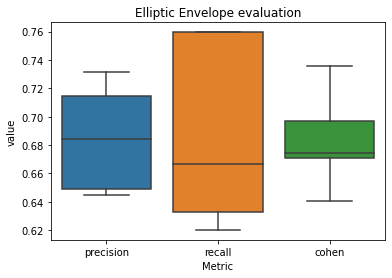

In [575]:
# the minmax scaler shouldn't effect the data since EllipticEnvelopes learns the scale too
# so it must be the quantile scaler that hurts the performance.
scaler = MinMaxScaler()
X_train_mm = scaler.fit_transform(X_unscaled)

model = EllipticEnvelope(contamination=y_unscaled.mean(), support_fraction=.95)
results = eval_model(model, X_train_mm, y_unscaled)

plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("Elliptic Envelope evaluation")
plt.show()

In [ ]:
model = EllipticEnvelope(contamination=dummy_y.mean(), support_fraction=0.95)
dummy_results = eval_model(model, dummy_X, dummy_y)

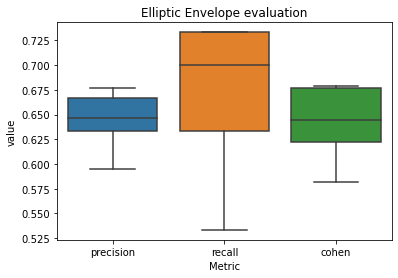

In [ ]:
plt.figure()
sns.boxplot(x="variable", y="value", data=dummy_results.melt())
plt.xlabel("Metric")
plt.title("Elliptic Envelope evaluation")
plt.show()

### Isolation Forest 

Second, a non-parametric method is the Isolation Forest. The idea is that a decision tree can isolate outlier data points (by splitting the data along features) by much shorter branches than inliers. We randomly select features and split values, recursively partitioning our data. The path length, averaged over a forest of such random trees, is a measure of inlier-ness: the longer the path the more regular the data point is.

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).

In [45]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=50, contamination=y_train.mean(),)
results = eval_model(model, X_train, y_train)

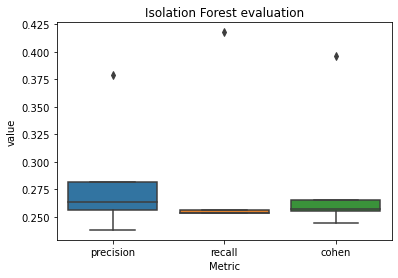

In [46]:
plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("Isolation Forest evaluation")
plt.show()

In [ ]:
model = IsolationForest(n_estimators=50, contamination=dummy_y.mean(),)
dummy_results = eval_model(model, dummy_X, dummy_y)

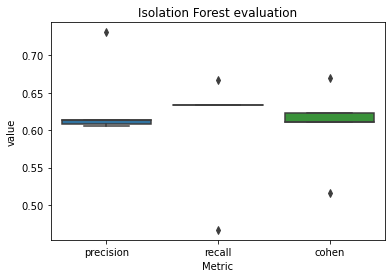

In [ ]:
plt.figure()
sns.boxplot(x="variable", y="value", data=dummy_results.melt())
plt.xlabel("Metric")
plt.title("Isolation Forest evaluation")
plt.show()

### Local Outlier Factors 

This is a non-parametric, density-based method that finds outliers by looking for data points which have significantly lower local densities than their neighbouring points. The rough algorithm is as follows:

1. Find the k-nearest neighbors and use the distance to estimate a local density;
2. Compare local densities with neighbours to detect outliers.

LOF being a distance-based method, it's important that our data is scaled. See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

Running this on the full data set takes a lot of time.

In [ ]:
%%time

from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=5, contamination=y.mean(), n_jobs=-1) # n_neighbours should be tuned

results = eval_model(model, X_train, y_train)

In [ ]:
plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("LOF evaluation")
plt.show()

Again, the dummy data:

In [ ]:
model = LocalOutlierFactor(n_neighbors=10, contamination=dummy_y.mean(), n_jobs=-1, novelty=True) # n_neighbours should be tuned

dummy_results = eval_model(model, dummy_X, dummy_y)

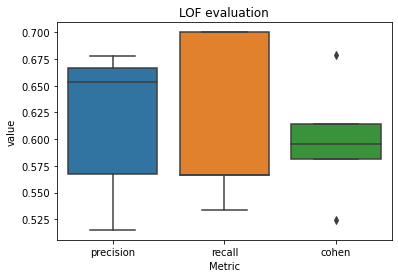

In [ ]:
plt.figure()
sns.boxplot(x="variable", y="value", data=dummy_results.melt())
plt.xlabel("Metric")
plt.title("LOF evaluation")
plt.show()

<a id="Randomized_autoencoders"></a>
<h2 style="background-color:#9b96d9;"> Randomized autoencoders </h2>

We will build an autoencoder class that can mask connections in its layers.

In [23]:
class RandAE(tf.keras.Sequential):
    def __init__(self, input_dim, hidden_dims, drop_ratio=0.5, **kwargs):
        super(RandAE, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.drop_ratio = drop_ratio
        
        self.layer_masks = dict()
        
        self.build_model()
                
    def build_model(self) -> None:
        """
        Adds the layers and records masks.
        """
        
        self.add(layers.Input(self.input_dim, name="input"))
        
        for i, dim in enumerate(self.hidden_dims):
            layer_name = f"hidden_{i}"
            layer = layers.Dense(dim, 
                                 activation="relu" if i > 0 else "sigmoid", 
                                 name=layer_name)
            self.add(layer)
            
            # add layer mask
            self.layer_masks[layer_name] = self.get_mask(layer)
        
        layer_name = "output"
        output_layer = layers.Dense(self.input_dim, activation="sigmoid", name=layer_name)
        self.add(output_layer)
        self.layer_masks[layer_name] = self.get_mask(output_layer)
            
    def get_mask(self, layer) -> np.ndarray:
        """
        Build mask for a layer.
        """
        
        shape = layer.input_shape[1], layer.output_shape[1]
        
        return np.random.choice([0., 1.], size=shape, p=[self.drop_ratio, 1-self.drop_ratio])
        
    def load_masks(self, mask_pickle_path) -> None:
        """
        Load the masks from a pickled dictionary.
        """
        
        with open(mask_pickle_path, 'rb') as handle:
            self.layer_masks = pickle.load(handle)    
            
    def get_encoder(self) -> keras.Sequential:
        """
        Get the encoder from the full model.
        """
        
        n_layers = (len(self.hidden_dims)+1)//2
        encoder_layers = [layers.Input(self.input_dim)] + self.layers[:n_layers]

        return keras.Sequential(encoder_layers)
        
    
    def mask_weights(self) -> None:
        """
        Apply the masks to each layer in the encoder and decoder.
        """
        
        for layer in self.layers:
            layer_name = layer.name
            if layer_name in self.layer_masks:
                masked_w = layer.weights[0].numpy()*self.layer_masks[layer_name]
                b = layer.weights[1].numpy()
                layer.set_weights((masked_w, b))        

    def call(self, data, training=True) -> tf.Tensor:
        
        # mask the weights before original forward pass
        self.mask_weights()
        
        return super().call(data)

We can preform some sanity checks on our model:

In [24]:
# test compile
model = RandAE(32, [16, 8, 4, 8, 16])
model.compile(optimizer="adam", loss="mse", run_eagerly=True)

In [25]:
# structure
model.summary()

Model: "rand_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 16)                528       
_________________________________________________________________
hidden_1 (Dense)             (None, 8)                 136       
_________________________________________________________________
hidden_2 (Dense)             (None, 4)                 36        
_________________________________________________________________
hidden_3 (Dense)             (None, 8)                 40        
_________________________________________________________________
hidden_4 (Dense)             (None, 16)                144       
_________________________________________________________________
output (Dense)               (None, 32)                544       
Total params: 1,428
Trainable params: 1,428
Non-trainable params: 0
_________________________________________________________

In [26]:
# check weights before first call
for layer in model.layers:
    pct = np.round((layer.weights[0].numpy() == 0).mean()*100, 2)
    print(f"{layer.name} has {pct}% exact-0 weights.")

hidden_0 has 0.0% exact-0 weights.
hidden_1 has 0.0% exact-0 weights.
hidden_2 has 0.0% exact-0 weights.
hidden_3 has 0.0% exact-0 weights.
hidden_4 has 0.0% exact-0 weights.
output has 0.0% exact-0 weights.


In [27]:
# test forward with sample data
data = np.random.randn(128, 32)
output = model(data)

In [28]:
# print 0 weight ratios again
for layer in model.layers:
    pct = np.round((layer.weights[0].numpy() == 0).mean()*100, 2)
    print(f"{layer.name} has {pct}% exact-0 weights.")

hidden_0 has 51.37% exact-0 weights.
hidden_1 has 50.78% exact-0 weights.
hidden_2 has 59.38% exact-0 weights.
hidden_3 has 53.12% exact-0 weights.
hidden_4 has 51.56% exact-0 weights.
output has 53.52% exact-0 weights.


The weights look good!

<a id="Outliers_on_the_latent_manifold"></a>
<h2 style="background-color:#9b96d9;"> Outliers on the latent manifold </h2>

We can do a quick EDA-type test run and see if our model can learn a better latent represenation of the data. Note that 
- our sigmoid activation in the last layer require the data to be scaled between 0 and 1;
- we set `drop_ratio=0` so we have a regular autoencoder.

In [29]:
model = RandAE(X_train.shape[1], [16], drop_ratio=0) # shallow AE
model.compile(optimizer="adam", loss="mse", run_eagerly=True)

print(f"Baseline loss: {np.square(X_train - X_train.mean(axis=0)).mean()}")

history = model.fit(X_train, X_train, epochs=5, batch_size=128)

Baseline loss: 0.009262252235319525
Epoch 1/5
1781/1781 [==============================] - 19s 11ms/step - loss: 0.0082
Epoch 2/5
1781/1781 [==============================] - 19s 10ms/step - loss: 0.0048
Epoch 3/5
1781/1781 [==============================] - 18s 10ms/step - loss: 0.0033
Epoch 4/5
1781/1781 [==============================] - 17s 10ms/step - loss: 0.0030
Epoch 5/5
1781/1781 [==============================] - 17s 10ms/step - loss: 0.0028


The baseline MSE shows that there was definitely a fair amount of learning.

Now we can use the encoder to get the latent representation of the plot data:

In [30]:
encoder = model.get_encoder()

vis_data_latent = encoder.predict(vis_data)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(vis_data_latent)

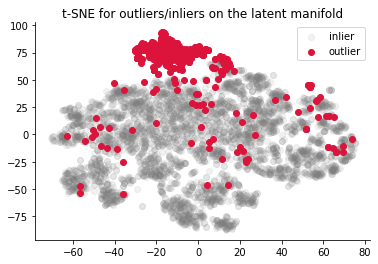

In [31]:
plt.figure()
plt.scatter(tsne_data[vis_labels == 0, 0], 
            tsne_data[vis_labels == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[vis_labels == 1, 0], 
            tsne_data[vis_labels == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers on the latent manifold")
plt.savefig("tsne_wordline_latent_2.png")
plt.show()

The image changed somewhat but pretty similar overall: note that this was plotted based on the 16-dim latent representation instead the original features.

<a id="Detecting_outliers_based_on_reconstruction_loss"></a>
<h2 style="background-color:#9b96d9;"> Detecting outliers based on reconstruction loss </h2>

We can look for the outliers using our autoencoder by selecting the points with the largest reconstruction loss.

In [32]:
input_data = X_test
input_labels = y_test

# make ensemble predictions
pred = model.predict(input_data)

# calculate reconstruction MSE
reconstruction_loss = np.square(pred - input_data).mean(axis=1)

# set threshold by the population contamination
threshold = np.quantile(reconstruction_loss, 1-input_labels.mean())
outlier_pred = np.where(reconstruction_loss > threshold, 1, 0)

# evaluate
cr = classification_report(input_labels, outlier_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.46      0.46        98

    accuracy                           1.00     56962
   macro avg       0.73      0.73      0.73     56962
weighted avg       1.00      1.00      1.00     56962



A more wholesome picture comes from looking at the full Precision-Recall curve.

In [33]:
# we minmax scale our loss to resemble probabilities
min_ = reconstruction_loss.min()
max_ = reconstruction_loss.max()
scaled_loss = (reconstruction_loss - min_)/(max_ - min_)

prec, recall, thresholds = precision_recall_curve(input_labels, scaled_loss)

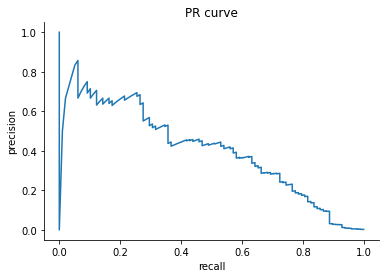

In [34]:
plt.figure()
plt.plot(recall, prec)
plt.xlabel("recall")
plt.ylabel("precision")
sns.despine()
plt.title("PR curve")
plt.show()

Finally, we can look at Cohen's kappa. This is a measure of agreement between two arrays that takes into account by-chance equality. The values range between 1 and -1 with the former being the best score.

In [35]:
cohen_kappa_score(input_labels, outlier_pred)

0.4582516250732144

<a id="Data_loaders_for_adaptive_learning"></a>
<h2 style="background-color:#9b96d9;"> Data loaders for adaptive learning </h2>

We want to change our training data as we progress during training and feed more and more samples to the model in later epochs. For this, we will write a custom data loader.

In [64]:
from tensorflow import keras
import warnings, math


## NOTE: does not work as expected - see comments below
class AdaptiveDataGenerator(keras.utils.Sequence):
    def __init__(self, x, batch_size, alpha=1.01, subsample=0.3, shuffle=True, verbose=False):
        self.x = x
        self.subsample = subsample
        self.verbose = verbose
        
        if self.subsample:
            sample_idx = np.random.choice(self.x.shape[0], size=int(self.subsample*self.x.shape[0]))
            self.x = self.x[sample_idx]
            
        self.batch_size = batch_size
        
        # adaptive learning params
        self.alpha = alpha
        if self.alpha <= 1:
            raise warnings.warn("Alpha should be set to > 1 to increase training data.")
        self.shuffle = shuffle
        
        # per epoch variables
        self.epoch = 0
        self.train_ratio = 0.5
        self.current_x = None
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.current_x) / self.batch_size)
    
    def __getitem__(self, idx):
        """
        Return a batch for autoencoder training.
        """
        
        batch = self.current_x[idx*self.batch_size: (idx+1)*self.batch_size]
        
        return batch, batch
    
    def on_epoch_end(self):
        """
        Called before training and after every epoch to include more and more training data.
        """
        
        # slice training data for the next epoch
        slice_idx = int(self.train_ratio*self.x.shape[0])
        self.current_x = self.x[:slice_idx]
        
        # shuffle rows to mix data in different batches
        if self.shuffle:
            rand_idx = np.arange(self.current_x.shape[0])
            np.random.shuffle(rand_idx)
            self.current_x = self.current_x[rand_idx]
            
        if self.verbose:
            print(f"Epoch {self.epoch+1} -- {self.current_x.shape[0]/self.x.shape[0]*100}% data")
        
        # update training params
        self.train_ratio = min(self.train_ratio*self.alpha, 1)
        self.epoch += 1

Some sanity checks:

In [ ]:
import unittest

class TestAdaptiveDataGenerator(unittest.TestCase):
    def setUp(self):
        self.data = np.random.randn(1000, 10)
        self.batch_size = 10
        self.generator = AdaptiveDataGenerator(self.data, self.batch_size, subsample=0.5, alpha=1.2, verbose=True,)
        self.model = RandAE(input_dim=10, hidden_dims=[16, 8, 16])
        self.model.compile(optimizer="adam", loss="mse", run_eagerly=True)
    
    def test_fit(self):
        self.model.fit_generator(generator=self.generator,
                                 epochs=10, 
                                 workers=1)
        
unittest.main(argv=[''], verbosity=2, exit=False)

There was an issue here that the number of steps per epoch is not changing, even though the batch size is fixed and we increase the data size. The problem is that `fit_generator` calls the `len` method only at the beginning of the training so the `steps_per_epoch` stays whatever is set initially.

1. We could write a custom training loop calling fit `epochs` times on different data sets. Probably the simplest work around.
2. We could increase the `batch_size` as we train to cover more of the training data; this seems an ok alternative as we start from 50% of the data already so worse case we double the batch size. There is further evidence that supports that [increasing the batch size is similar (if not better) to learning rate annealing](https://openreview.net/pdf?id=B1Yy1BxCZ).
3. There is a dirty fix: [change the Keras source code](https://github.com/keras-team/keras/issues/10615#issuecomment-664031073).

I will go with option 2.

In [88]:
from tensorflow import keras
import warnings, math


class BatchAdaptiveDataGenerator(keras.utils.Sequence):
    def __init__(self, x, start_batch_size, epochs, subsample=0.3, start_data_ratio=0.5, shuffle=True, verbose=False):
        self.x = x
        self.subsample = subsample 
        self.verbose = verbose
        
        if self.subsample:
            sample_idx = np.random.choice(self.x.shape[0], size=int(self.subsample*self.x.shape[0]))
            self.x = self.x[sample_idx]
        
        # initial training params
        self.epochs = epochs
        self.start_batch_size = start_batch_size
        self.start_data_ratio = start_data_ratio
        self.steps_per_epoch = int(self.start_data_ratio*self.x.shape[0]/self.start_batch_size)
        
        # adaptive learning param to increase batch_size after each epoch
        self.alpha = np.exp(np.log(1/self.start_data_ratio)/self.epochs)
        self.shuffle = shuffle
        
        # per epoch variables
        self.epoch = 0
        self.current_x = None
        self.current_batch_size = self.start_batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return self.steps_per_epoch
    
    def __getitem__(self, idx):
        """
        Return a batch for autoencoder training.
        """
        
        batch = self.current_x[idx*self.current_batch_size: (idx+1)*self.current_batch_size]
        
        return batch, batch
    
    def on_epoch_end(self):
        """
        Called before training and after every epoch to include more and more training data.
        """
        
        # update training data by slicing and shuffling
        current_x_size = int(self.current_batch_size*self.steps_per_epoch)
        self.current_x = self.x[:current_x_size]
        
        # shuffle rows to mix data in different batches
        if self.shuffle:
            rand_idx = np.arange(self.current_x.shape[0])
            np.random.shuffle(rand_idx)
            self.current_x = self.current_x[rand_idx]
            
        if self.verbose:
            print(f"Epoch {self.epoch+1} -- {self.current_x.shape[0]/self.x.shape[0]*100}% data")
        
        # update batch size
        self.current_batch_size = int(self.start_batch_size * self.alpha**self.epoch)
        self.epoch += 1

In [ ]:
class TestBatchAdaptiveDataGenerator(unittest.TestCase):
    def setUp(self):
        self.data = np.random.randn(10000, 10)
        self.batch_size = 32
        self.epochs = 10
        self.generator = BatchAdaptiveDataGenerator(self.data, self.batch_size, self.epochs, subsample=0.5, verbose=True,)
        self.model = RandAE(input_dim=10, hidden_dims=[16, 8, 16])
        self.model.compile(optimizer="adam", loss="mse", run_eagerly=True)
   
    def test_fit(self):
        self.model.fit_generator(generator=self.generator,
                                 epochs=10, 
                                 workers=1)
        
unittest.main(argv=[''], verbosity=2, exit=False)

<a id="Training_the_ensemble"></a>
<h2 style="background-color:#9b96d9;"> Training the ensemble </h2>

We would like to set the `alpha` parameter that controls the amount of data used so that at the end of training, we use the full sample.

In [98]:
# baseline loss
np.square(X_train - X_train.mean(axis=0)).mean()

0.009271638876464648

In [ ]:
MODEL_PARAMS ={"input_dim": X_train.shape[1],
               "hidden_dims": [16],
               "drop_ratio": 0.33}

COMPILE_PARAMS = {"optimizer": keras.optimizers.Adam(learning_rate=1e-3),
                 "loss": keras.losses.MeanSquaredError(),
                 "run_eagerly": True,}

EPOCHS = 50

DATA_GEN_PARAMS = {"start_batch_size": 128, 
                   "epochs": EPOCHS,
                   "subsample": 0.3,}

FIT_PARAMS = {"epochs": EPOCHS,
              "verbose": 1}

n_models = 50
ensemble = []

from tqdm import tqdm
import pickle

for i in tqdm(range(n_models)):
    model = RandAE(**MODEL_PARAMS)
    model.compile(**COMPILE_PARAMS)
    
    data_generator = BatchAdaptiveDataGenerator(X_train, **DATA_GEN_PARAMS)
    model.fit_generator(generator=data_generator, **FIT_PARAMS)

    # save the weights and mask
    model.save_weights(f"models/randae_model_{i}")
    with open(f'model_{i}_masks.pickle', 'wb') as handle:
        pickle.dump(model.layer_masks, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    ensemble.append(model)

After running a few experiments, it looks that shallow AE's are learning much better in this setup. I would implement layer-wise pretraining next to address this (as in the original RandNet paper).

<a id="Evaluating_the_ensemble"></a>
<h2 style="background-color:#9b96d9;"> Evaluating the ensemble </h2>

We ran the experiment using the python scripts and can load the evaluation results back. The two main runs compare preparing the data with quantile scaler plus minmax and minmax scaler only.

In [84]:
# MM only, smaller subsampling with larger model
last_experiment = "models/eval_results_2020-12-10-09-51-25.pickle"

# Own + MM: my robust scaler with minmax
own_experiment = "models/eval_results_2020-12-10-08-47-54.pickle"

# MM: minmax scaling of the data only
minmax_experiment = "models/eval_results_2020-12-09-22-36-15.pickle"

# QS+MM: quantile and minmax scaling -- performed worse in the end.
quantile_minmax_experiment = "models/eval_results_2020-12-09-09-00-39.pickle"

with open(last_experiment, "rb") as handle:
    results = pickle.load(handle)

We can look more closely at the reconstruction losses.

In [72]:
reconstruction_loss = results["reconstruction_loss"]

Looking at the different components, the means and variances of the component losses are quite close.

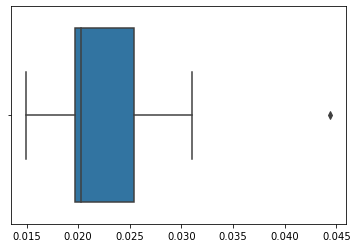

In [73]:
sns.boxplot(reconstruction_loss.mean(axis=0))
plt.show()

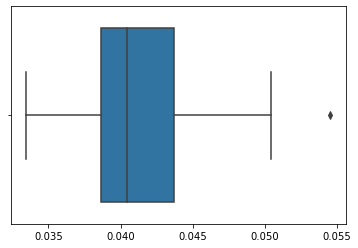

In [74]:
sns.boxplot(reconstruction_loss.std(axis=0))
plt.show()

Own: pretty even std and means with one outlier component.

MM: Interesting to see a few outliers here, there are three components (out of 25) from the ensemble that fit quite differently than the others.

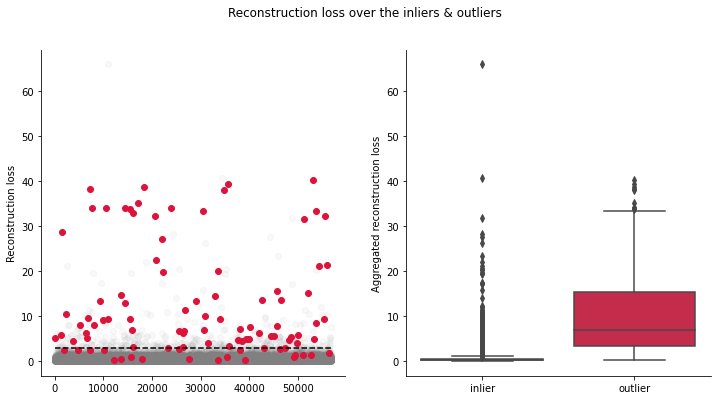

In [87]:
# scale the reconstruction loss to account for those outliers.
scaler = StandardScaler(with_mean=False)
reconstruction_loss = scaler.fit_transform(reconstruction_loss, )

# aggregate loss across the ensemble components
agg_loss = np.median(reconstruction_loss, axis=1)

threshold = 3

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(np.where(y_test==0)[0], 
            agg_loss[(y_test == 0).ravel()], 
            c="grey", 
            alpha=0.05)
plt.scatter(np.where(y_test == 1)[0], 
            agg_loss[(y_test == 1).ravel()], 
            c="crimson", 
            alpha=1)
plt.hlines(threshold, xmin=0, xmax=y_test.shape[0], linestyles="--", colors="black")
plt.ylabel("Reconstruction loss")
sns.despine()

ax = plt.subplot(1, 2, 2)
plot_data = pd.DataFrame(data={"agg_loss": agg_loss, "label": np.where(y_test.ravel() == 0, "inlier", "outlier")})
sns.boxplot(y="agg_loss", x="label", data=plot_data, palette=["grey", "crimson"], ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Aggregated reconstruction loss")
sns.despine()

plt.suptitle("Reconstruction loss over the inliers & outliers")
plt.show()

MM scaling only: better results than QS+MM scaling, inlier loss is much more concentrated with.

QS+MM scaling: The outliers have consistently high reconstruction loss but the main issue seems to be that there are a fair amount of inlier data points with high median reconstruction loss. It would be interesting to see why this happens and to look at these data points specifically. I wonder if these overlap with those inlier clusters we initially observed. Threshold around 0.5 looks optimal.

In [76]:
bigloss_idx = np.where(agg_loss > threshold)[0]
smallloss_idx = np.random.choice(np.where(agg_loss <= threshold)[0], size=(2500,))
idx = np.concatenate([bigloss_idx, smallloss_idx], axis=0)
plot_X = X_test[idx]
plot_y = y_test[idx].ravel()
plot_loss = agg_loss[idx]

In [77]:
plot_X.shape

(2910, 30)

In [78]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(plot_X)

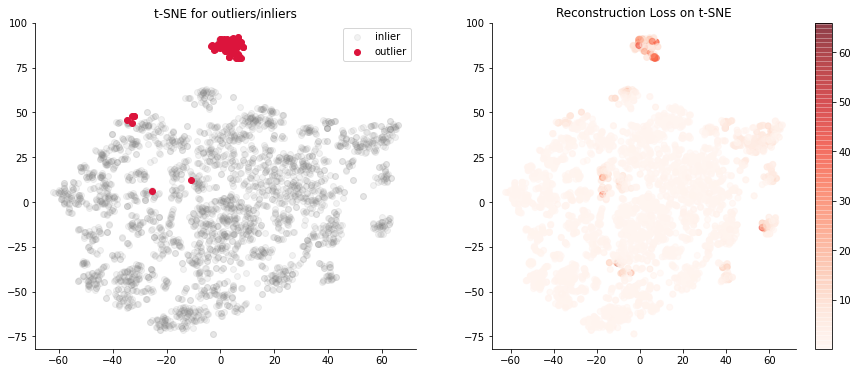

In [79]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(tsne_data[plot_y == 0, 0], 
            tsne_data[plot_y == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[plot_y == 1, 0], 
            tsne_data[plot_y == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers")

plt.subplot(1, 2, 2)
plt.scatter(tsne_data[:, 0],
            tsne_data[:, 1],
            c=plot_loss, cmap="Reds", alpha=0.5)
plt.colorbar()
plt.title("Reconstruction Loss on t-SNE")
sns.despine()
#plt.savefig("assets/tsne_reconstruction_loss.png")
plt.show()

Own: this gives the worse reconstruction losses for inliers... clearly not the right approach :)

MM: mixed result here. This picture supports the previous observation that the reconstruction loss is much more concentrated for inliers (although there are a fair number of badly learned inlier points). t-SNE very nicely separates the outliers but surprisingly there are a few points there with small reconstruction loss.

QS+MM: What I see is that autoencoders are nicely fitted on the 'central' data regioun but struggle to reproduce plenty of the inliers around the outer regions. This relates to the observations we made early on about how some of the inliers formed similar clusters at the periphery.

As for model accuracy with respect the true labels:

In [85]:
prec, recall, thresholds = results["precision_recall_curve"]

best_idx = np.argmin(np.abs(prec-recall))
best_prec, best_recall = prec[best_idx], recall[best_idx]
print(f"Best precision {np.round(best_prec, 2)}, "\
      f"recall: {np.round(best_recall, 2)} at {np.round(thresholds[best_idx], 2)} threshold.")

Best precision 0.45, recall: 0.45 at 0.12 threshold.


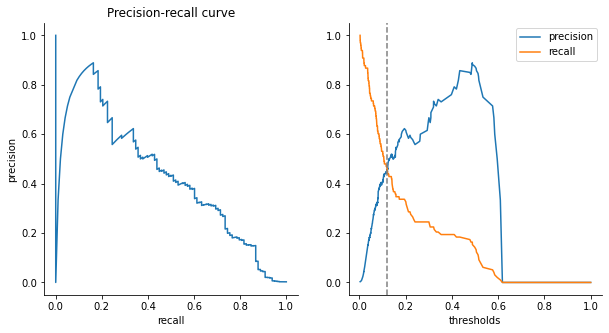

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(recall, prec)
axs[0].set_xlabel("recall")
axs[0].set_ylabel("precision")
axs[0].set_title("Precision-recall curve")
axs[1].plot(thresholds, prec[:-1], label="precision")
axs[1].plot(thresholds, recall[:-1], label="recall")
axs[1].axvline(thresholds[best_idx], 0, 1, c="grey", linestyle="--")
axs[1].set_xlabel("thresholds")
sns.despine()
plt.legend()
plt.show()



Own: looks worse than MM...

MM: looks better than QS+MM, we can get up to 47% precision/recall.

QS+MM: The precision-recall curves show that the initial results are not stellar, we get the best score with a threshold around 0.5 where both the precision and recall are around 40%, this is somewhat under the elliptic envelope scores that were around 68% recall and 66% precision.

My best bet, given how much better the elliptic envelope is on the unscaled data and how bad both the elliptic envelope and autoencoders are on the scaled, is that my scaling is not appropriate.